# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


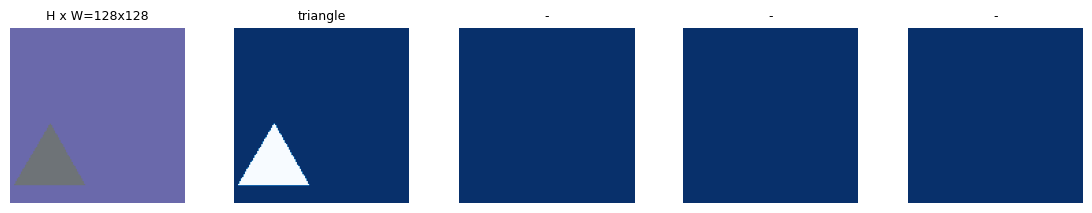

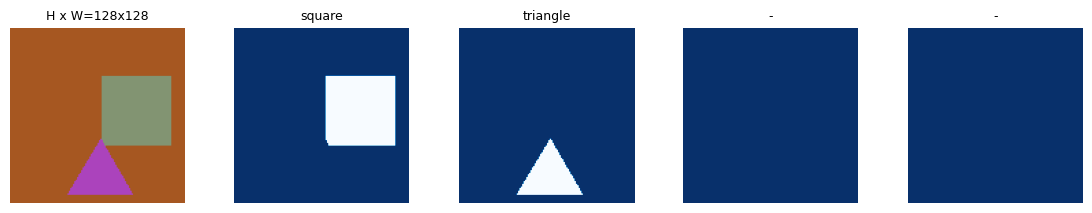

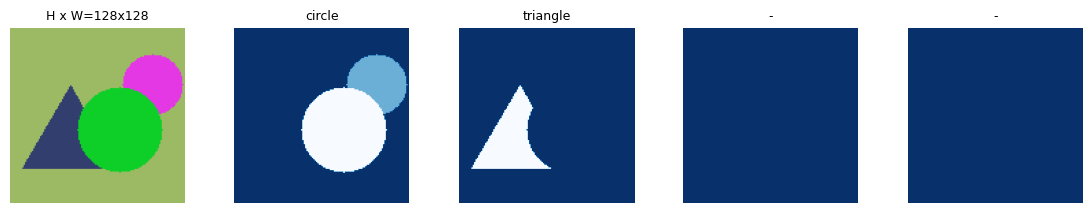

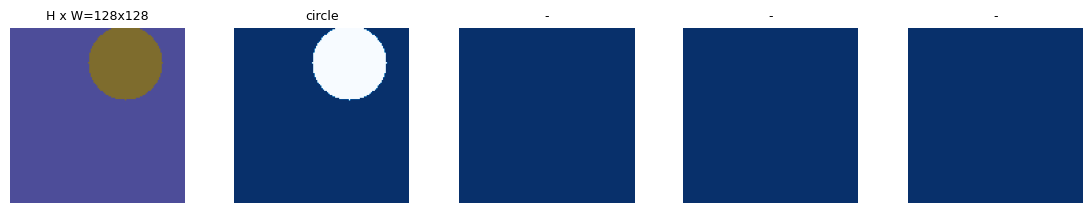

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\kenes\python_workplace\Mask_RCNN-master\logs\shapes20230725T0104\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/1


C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/100 [..............................] - ETA: 16:18 - loss: 9.1291 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 4.4563 - mrcnn_class_loss: 1.7263 - mrcnn_bbox_loss: 0.9662 - mrcnn_mask_loss: 1.9030

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 8:28 - loss: 7.2990 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 2.7391 - mrcnn_class_loss: 1.6284 - mrcnn_bbox_loss: 1.1200 - mrcnn_mask_loss: 1.7432 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 5:51 - loss: 8.0369 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 3.4096 - mrcnn_class_loss: 1.3574 - mrcnn_bbox_loss: 1.3445 - mrcnn_mask_loss: 1.8504

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 4:32 - loss: 7.9909 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 3.3978 - mrcnn_class_loss: 1.4955 - mrcnn_bbox_loss: 1.3174 - mrcnn_mask_loss: 1.6725

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 3:45 - loss: 7.9126 - rpn_class_loss: 0.1168 - rpn_bbox_loss: 3.4112 - mrcnn_class_loss: 1.5005 - mrcnn_bbox_loss: 1.3552 - mrcnn_mask_loss: 1.5289

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 3:13 - loss: 7.4008 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 3.0599 - mrcnn_class_loss: 1.3755 - mrcnn_bbox_loss: 1.3265 - mrcnn_mask_loss: 1.5357

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 2:50 - loss: 6.9501 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 2.7493 - mrcnn_class_loss: 1.3597 - mrcnn_bbox_loss: 1.2899 - mrcnn_mask_loss: 1.4584

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 2:32 - loss: 6.6931 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 2.5476 - mrcnn_class_loss: 1.3031 - mrcnn_bbox_loss: 1.2476 - mrcnn_mask_loss: 1.5002

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 2:19 - loss: 6.4430 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 2.3852 - mrcnn_class_loss: 1.2816 - mrcnn_bbox_loss: 1.2129 - mrcnn_mask_loss: 1.4579

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 2:08 - loss: 6.2207 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 2.2279 - mrcnn_class_loss: 1.2923 - mrcnn_bbox_loss: 1.1833 - mrcnn_mask_loss: 1.4117

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:59 - loss: 6.0539 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 2.1593 - mrcnn_class_loss: 1.2776 - mrcnn_bbox_loss: 1.1465 - mrcnn_mask_loss: 1.3695

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:51 - loss: 5.9495 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 2.1410 - mrcnn_class_loss: 1.2288 - mrcnn_bbox_loss: 1.1518 - mrcnn_mask_loss: 1.3282

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:45 - loss: 5.7975 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 2.0604 - mrcnn_class_loss: 1.2123 - mrcnn_bbox_loss: 1.1370 - mrcnn_mask_loss: 1.2882

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:39 - loss: 5.7120 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 2.0092 - mrcnn_class_loss: 1.2213 - mrcnn_bbox_loss: 1.1241 - mrcnn_mask_loss: 1.2517

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:34 - loss: 5.5265 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 1.9580 - mrcnn_class_loss: 1.1572 - mrcnn_bbox_loss: 1.0911 - mrcnn_mask_loss: 1.2184

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:30 - loss: 5.4645 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 1.9202 - mrcnn_class_loss: 1.1707 - mrcnn_bbox_loss: 1.0823 - mrcnn_mask_loss: 1.1914

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:26 - loss: 5.3470 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 1.8482 - mrcnn_class_loss: 1.1694 - mrcnn_bbox_loss: 1.0715 - mrcnn_mask_loss: 1.1616

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:23 - loss: 5.1346 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 1.7469 - mrcnn_class_loss: 1.1233 - mrcnn_bbox_loss: 1.0325 - mrcnn_mask_loss: 1.1398

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:19 - loss: 5.0252 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 1.7014 - mrcnn_class_loss: 1.0950 - mrcnn_bbox_loss: 1.0170 - mrcnn_mask_loss: 1.1210

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:16 - loss: 4.9089 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.6522 - mrcnn_class_loss: 1.0739 - mrcnn_bbox_loss: 0.9963 - mrcnn_mask_loss: 1.0978

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:14 - loss: 4.8208 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 1.6091 - mrcnn_class_loss: 1.0481 - mrcnn_bbox_loss: 0.9940 - mrcnn_mask_loss: 1.0825

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:11 - loss: 4.7415 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.5747 - mrcnn_class_loss: 1.0258 - mrcnn_bbox_loss: 0.9877 - mrcnn_mask_loss: 1.0659

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:09 - loss: 4.6571 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 1.5345 - mrcnn_class_loss: 1.0065 - mrcnn_bbox_loss: 0.9767 - mrcnn_mask_loss: 1.0523

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:07 - loss: 4.5672 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.4882 - mrcnn_class_loss: 0.9861 - mrcnn_bbox_loss: 0.9698 - mrcnn_mask_loss: 1.0379

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:05 - loss: 4.4792 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.4491 - mrcnn_class_loss: 0.9599 - mrcnn_bbox_loss: 0.9643 - mrcnn_mask_loss: 1.0232

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:03 - loss: 4.4110 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4240 - mrcnn_class_loss: 0.9399 - mrcnn_bbox_loss: 0.9563 - mrcnn_mask_loss: 1.0092

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:02 - loss: 4.3397 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.3939 - mrcnn_class_loss: 0.9189 - mrcnn_bbox_loss: 0.9496 - mrcnn_mask_loss: 0.9975

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:00 - loss: 4.2573 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.3658 - mrcnn_class_loss: 0.8978 - mrcnn_bbox_loss: 0.9286 - mrcnn_mask_loss: 0.9858

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 59s - loss: 4.2046 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.3538 - mrcnn_class_loss: 0.8830 - mrcnn_bbox_loss: 0.9129 - mrcnn_mask_loss: 0.9747 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 57s - loss: 4.1380 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.3198 - mrcnn_class_loss: 0.8690 - mrcnn_bbox_loss: 0.9056 - mrcnn_mask_loss: 0.9647

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 56s - loss: 4.0803 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.2872 - mrcnn_class_loss: 0.8562 - mrcnn_bbox_loss: 0.9037 - mrcnn_mask_loss: 0.9544

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 54s - loss: 3.9971 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.2571 - mrcnn_class_loss: 0.8317 - mrcnn_bbox_loss: 0.8866 - mrcnn_mask_loss: 0.9442

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 53s - loss: 3.9673 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.2520 - mrcnn_class_loss: 0.8272 - mrcnn_bbox_loss: 0.8758 - mrcnn_mask_loss: 0.9360

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 51s - loss: 3.9202 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.2315 - mrcnn_class_loss: 0.8153 - mrcnn_bbox_loss: 0.8718 - mrcnn_mask_loss: 0.9258

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 50s - loss: 3.8719 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.2074 - mrcnn_class_loss: 0.8075 - mrcnn_bbox_loss: 0.8653 - mrcnn_mask_loss: 0.9160

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 48s - loss: 3.8300 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.1839 - mrcnn_class_loss: 0.7907 - mrcnn_bbox_loss: 0.8765 - mrcnn_mask_loss: 0.9045

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 47s - loss: 3.7955 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.1730 - mrcnn_class_loss: 0.7787 - mrcnn_bbox_loss: 0.8704 - mrcnn_mask_loss: 0.8984

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 45s - loss: 3.7655 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.1575 - mrcnn_class_loss: 0.7742 - mrcnn_bbox_loss: 0.8638 - mrcnn_mask_loss: 0.8939

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 44s - loss: 3.7086 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.1319 - mrcnn_class_loss: 0.7576 - mrcnn_bbox_loss: 0.8564 - mrcnn_mask_loss: 0.8878

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 42s - loss: 3.6688 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.1112 - mrcnn_class_loss: 0.7514 - mrcnn_bbox_loss: 0.8529 - mrcnn_mask_loss: 0.8796

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 41s - loss: 3.6326 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.0987 - mrcnn_class_loss: 0.7414 - mrcnn_bbox_loss: 0.8455 - mrcnn_mask_loss: 0.8739

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 40s - loss: 3.6007 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.0842 - mrcnn_class_loss: 0.7370 - mrcnn_bbox_loss: 0.8398 - mrcnn_mask_loss: 0.8680

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 39s - loss: 3.5704 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.0695 - mrcnn_class_loss: 0.7334 - mrcnn_bbox_loss: 0.8339 - mrcnn_mask_loss: 0.8625

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 37s - loss: 3.5268 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.0580 - mrcnn_class_loss: 0.7236 - mrcnn_bbox_loss: 0.8218 - mrcnn_mask_loss: 0.8538

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 36s - loss: 3.4798 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.0452 - mrcnn_class_loss: 0.7108 - mrcnn_bbox_loss: 0.8106 - mrcnn_mask_loss: 0.8445

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 35s - loss: 3.4436 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.0350 - mrcnn_class_loss: 0.6959 - mrcnn_bbox_loss: 0.8052 - mrcnn_mask_loss: 0.8400

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 34s - loss: 3.4020 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.0174 - mrcnn_class_loss: 0.6839 - mrcnn_bbox_loss: 0.7982 - mrcnn_mask_loss: 0.8363

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 33s - loss: 3.3721 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.0019 - mrcnn_class_loss: 0.6804 - mrcnn_bbox_loss: 0.7918 - mrcnn_mask_loss: 0.8326

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 32s - loss: 3.3344 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 0.9863 - mrcnn_class_loss: 0.6711 - mrcnn_bbox_loss: 0.7882 - mrcnn_mask_loss: 0.8244

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 31s - loss: 3.3102 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.9812 - mrcnn_class_loss: 0.6595 - mrcnn_bbox_loss: 0.7848 - mrcnn_mask_loss: 0.8214

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 30s - loss: 3.2780 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 0.6519 - mrcnn_bbox_loss: 0.7769 - mrcnn_mask_loss: 0.8167

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 29s - loss: 3.2501 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.9648 - mrcnn_class_loss: 0.6435 - mrcnn_bbox_loss: 0.7673 - mrcnn_mask_loss: 0.8128

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 28s - loss: 3.2216 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.9505 - mrcnn_class_loss: 0.6364 - mrcnn_bbox_loss: 0.7638 - mrcnn_mask_loss: 0.8101

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 27s - loss: 3.2074 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.9459 - mrcnn_class_loss: 0.6358 - mrcnn_bbox_loss: 0.7599 - mrcnn_mask_loss: 0.8059

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 26s - loss: 3.1888 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.9435 - mrcnn_class_loss: 0.6303 - mrcnn_bbox_loss: 0.7557 - mrcnn_mask_loss: 0.7998

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 25s - loss: 3.1845 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.9526 - mrcnn_class_loss: 0.6265 - mrcnn_bbox_loss: 0.7499 - mrcnn_mask_loss: 0.7960

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 24s - loss: 3.1670 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.9476 - mrcnn_class_loss: 0.6213 - mrcnn_bbox_loss: 0.7462 - mrcnn_mask_loss: 0.7927

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 24s - loss: 3.1507 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.9378 - mrcnn_class_loss: 0.6167 - mrcnn_bbox_loss: 0.7462 - mrcnn_mask_loss: 0.7914

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 23s - loss: 3.1289 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.9284 - mrcnn_class_loss: 0.6137 - mrcnn_bbox_loss: 0.7396 - mrcnn_mask_loss: 0.78

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 22s - loss: 3.1028 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.9216 - mrcnn_class_loss: 0.6046 - mrcnn_bbox_loss: 0.7321 - mrcnn_mask_loss: 0.7869

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 21s - loss: 3.0685 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.9113 - mrcnn_class_loss: 0.5972 - mrcnn_bbox_loss: 0.7239 - mrcnn_mask_loss: 0.7792

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 20s - loss: 3.0513 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.9039 - mrcnn_class_loss: 0.5953 - mrcnn_bbox_loss: 0.7192 - mrcnn_mask_loss: 0.7764

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 20s - loss: 3.0400 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.8990 - mrcnn_class_loss: 0.5965 - mrcnn_bbox_loss: 0.7147 - mrcnn_mask_loss: 0.7731

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 18s - loss: 3.0066 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.8845 - mrcnn_class_loss: 0.5870 - mrcnn_bbox_loss: 0.7110 - mrcnn_mask_loss: 0.7683

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations




C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 18s - loss: 2.9896 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.8757 - mrcnn_class_loss: 0.5804 - mrcnn_bbox_loss: 0.7118 - mrcnn_mask_loss: 0.7667

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 16s - loss: 2.9594 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.8658 - mrcnn_class_loss: 0.5766 - mrcnn_bbox_loss: 0.7034 - mrcnn_mask_loss: 0.7589

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 16s - loss: 2.9561 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 0.8590 - mrcnn_class_loss: 0.5833 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.7584

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 15s - loss: 2.9333 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.8530 - mrcnn_class_loss: 0.5768 - mrcnn_bbox_loss: 0.6977 - mrcnn_mask_loss: 0.7518

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 14s - loss: 2.9151 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.8459 - mrcnn_class_loss: 0.5740 - mrcnn_bbox_loss: 0.6943 - mrcnn_mask_loss: 0.7476

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 14s - loss: 2.8948 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 0.8385 - mrcnn_class_loss: 0.5697 - mrcnn_bbox_loss: 0.6899 - mrcnn_mask_loss: 0.74

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 13s - loss: 2.8844 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.8338 - mrcnn_class_loss: 0.5690 - mrcnn_bbox_loss: 0.6869 - mrcnn_mask_loss: 0.7422

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 12s - loss: 2.8755 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.8339 - mrcnn_class_loss: 0.5665 - mrcnn_bbox_loss: 0.6845 - mrcnn_mask_loss: 0.73

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 12s - loss: 2.8666 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.8294 - mrcnn_class_loss: 0.5646 - mrcnn_bbox_loss: 0.6847 - mrcnn_mask_loss: 0.7359

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 11s - loss: 2.8553 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.8264 - mrcnn_class_loss: 0.5636 - mrcnn_bbox_loss: 0.6814 - mrcnn_mask_loss: 0.7325

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 11s - loss: 2.8370 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.8193 - mrcnn_class_loss: 0.5600 - mrcnn_bbox_loss: 0.6780 - mrcnn_mask_loss: 0.7286

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 10s - loss: 2.8199 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.8109 - mrcnn_class_loss: 0.5549 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.7271

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 10s - loss: 2.7974 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.5501 - mrcnn_bbox_loss: 0.6700 - mrcnn_mask_loss: 0.7229

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 9s - loss: 2.7929 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.8002 - mrcnn_class_loss: 0.5519 - mrcnn_bbox_loss: 0.6687 - mrcnn_mask_loss: 0.7224 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 9s - loss: 2.7883 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.7945 - mrcnn_class_loss: 0.5546 - mrcnn_bbox_loss: 0.6684 - mrcnn_mask_loss: 0.7215

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 8s - loss: 2.7817 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7944 - mrcnn_class_loss: 0.5548 - mrcnn_bbox_loss: 0.6637 - mrcnn_mask_loss: 0.7196

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 7s - loss: 2.7767 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.7908 - mrcnn_class_loss: 0.5575 - mrcnn_bbox_loss: 0.6607 - mrcnn_mask_loss: 0.7187

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 7s - loss: 2.7609 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.7861 - mrcnn_class_loss: 0.5555 - mrcnn_bbox_loss: 0.6565 - mrcnn_mask_loss: 0.7141

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 6s - loss: 2.7491 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.7802 - mrcnn_class_loss: 0.5557 - mrcnn_bbox_loss: 0.6532 - mrcnn_mask_loss: 0.7118

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 6s - loss: 2.7405 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.7768 - mrcnn_class_loss: 0.5548 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.7103

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 5s - loss: 2.7272 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.7727 - mrcnn_class_loss: 0.5523 - mrcnn_bbox_loss: 0.6472 - mrcnn_mask_loss: 0.7073

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 5s - loss: 2.7155 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.7690 - mrcnn_class_loss: 0.5496 - mrcnn_bbox_loss: 0.6441 - mrcnn_mask_loss: 0.7057

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 5s - loss: 2.6967 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.7626 - mrcnn_class_loss: 0.5457 - mrcnn_bbox_loss: 0.6391 - mrcnn_mask_loss: 0.7025

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 4s - loss: 2.6881 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.7602 - mrcnn_class_loss: 0.5432 - mrcnn_bbox_loss: 0.6370 - mrcnn_mask_loss: 0.7013

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 4s - loss: 2.6758 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.7570 - mrcnn_class_loss: 0.5400 - mrcnn_bbox_loss: 0.6336 - mrcnn_mask_loss: 0.6989

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 3s - loss: 2.6688 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.7530 - mrcnn_class_loss: 0.5407 - mrcnn_bbox_loss: 0.6313 - mrcnn_mask_loss: 0.6978

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 3s - loss: 2.6641 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.7530 - mrcnn_class_loss: 0.5379 - mrcnn_bbox_loss: 0.6302 - mrcnn_mask_loss: 0.6973

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 2s - loss: 2.6535 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.5347 - mrcnn_bbox_loss: 0.6279 - mrcnn_mask_loss: 0.6966

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 1s - loss: 2.6232 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.7373 - mrcnn_class_loss: 0.5282 - mrcnn_bbox_loss: 0.6198 - mrcnn_mask_loss: 0.6930

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 1s - loss: 2.6199 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.7391 - mrcnn_class_loss: 0.5274 - mrcnn_bbox_loss: 0.6173 - mrcnn_mask_loss: 0.6916

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 0s - loss: 2.6160 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.5300 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.6898

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 0s - loss: 2.6117 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.7350 - mrcnn_class_loss: 0.5303 - mrcnn_bbox_loss: 0.6135 - mrcnn_mask_loss: 0.6889

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarni

100/100 [==============================] - 47s 466ms/step - loss: 2.6047 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.7320 - mrcnn_class_loss: 0.5307 - mrcnn_bbox_loss: 0.6110 - mrcnn_mask_loss: 0.6874 - val_loss: 1.7865 - val_rpn_class_loss: 0.0214 - val_rpn_bbox_loss: 0.4004 - val_mrcnn_class_loss: 0.4037 - val_mrcnn_bbox_loss: 0.4170 - val_mrcnn_mask_loss: 0.5441


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\kenes\python_workplace\Mask_RCNN-master\logs\shapes20230725T0104\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/100 [..............................] - ETA: 37:38 - loss: 2.0276 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6639 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.4658 - mrcnn_mask_loss: 0.6612

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 18:55 - loss: 1.7908 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4588 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.5973

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 12:39 - loss: 1.8478 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4202 - mrcnn_class_loss: 0.3616 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.6171

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 9:31 - loss: 1.7887 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.6210 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 7:39 - loss: 1.8151 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.5747

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 6:24 - loss: 1.7621 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.5263

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 5:29 - loss: 1.7086 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.3493 - mrcnn_mask_loss: 0.5123

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 4:49 - loss: 1.7142 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.5047

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 4:17 - loss: 1.7507 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.3179 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.5140

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 3:52 - loss: 1.7963 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.3478 - mrcnn_mask_loss: 0.4943

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 3:31 - loss: 1.8247 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.6192 - mrcnn_class_loss: 0.3192 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.5000

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 3:14 - loss: 1.8627 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6181 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.4947

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 2:59 - loss: 1.9326 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5984 - mrcnn_class_loss: 0.4182 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.5119

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 2:46 - loss: 1.8988 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5846 - mrcnn_class_loss: 0.4117 - mrcnn_bbox_loss: 0.3733 - mrcnn_mask_loss: 0.5077

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 2:35 - loss: 1.8635 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.4109 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.5033

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 2:26 - loss: 1.8368 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5551 - mrcnn_class_loss: 0.4032 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.4937

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 2:17 - loss: 1.8432 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5677 - mrcnn_class_loss: 0.3847 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.5028

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 2:09 - loss: 1.7956 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.4990

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 2:03 - loss: 1.7802 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.3675 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.4977

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:56 - loss: 1.7703 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5475 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.4909

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:51 - loss: 1.7628 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5357 - mrcnn_class_loss: 0.3639 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.4971

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:45 - loss: 1.7791 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5282 - mrcnn_class_loss: 0.3720 - mrcnn_bbox_loss: 0.3559 - mrcnn_mask_loss: 0.5029

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:41 - loss: 1.7711 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.3642 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.5034

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:36 - loss: 1.7593 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.3589 - mrcnn_bbox_loss: 0.3519 - mrcnn_mask_loss: 0.5084

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:32 - loss: 1.7145 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.3506 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.4998

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:28 - loss: 1.7001 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.3533 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.5012

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:25 - loss: 1.6953 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4826 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.5066

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:22 - loss: 1.6823 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4751 - mrcnn_class_loss: 0.3555 - mrcnn_bbox_loss: 0.3306 - mrcnn_mask_loss: 0.5030

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 1:19 - loss: 1.6931 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4768 - mrcnn_class_loss: 0.3657 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.5018

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 1:16 - loss: 1.6797 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.3566 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.5002

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 1:13 - loss: 1.6646 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4733 - mrcnn_class_loss: 0.3523 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.4945

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 1:10 - loss: 1.6690 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.4935

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 1:08 - loss: 1.6668 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4759 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.4927

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 1:05 - loss: 1.6706 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.4992

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 1:03 - loss: 1.6949 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.3725 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.5038

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 1:01 - loss: 1.6706 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.3652 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.5006

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 59s - loss: 1.6637 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.3654 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.5042 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 57s - loss: 1.6543 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4518 - mrcnn_class_loss: 0.3579 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.5066

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 55s - loss: 1.6629 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.3625 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.5094

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 53s - loss: 1.6627 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4596 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.5057

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 52s - loss: 1.6538 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.3588 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.5039

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 50s - loss: 1.6557 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4539 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.3167 - mrcnn_mask_loss: 0.5043

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 49s - loss: 1.6476 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.3577 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.5022

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 47s - loss: 1.6507 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.3570 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.5009

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 45s - loss: 1.6582 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.3555 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.5011

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 44s - loss: 1.6495 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.3553 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.5002

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 43s - loss: 1.6332 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.3516 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.4962

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 41s - loss: 1.6202 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.4988

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 40s - loss: 1.6170 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.4972

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 39s - loss: 1.6161 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4601 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.4945

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 38s - loss: 1.6204 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4587 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.4969

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 36s - loss: 1.6217 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.4986

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 35s - loss: 1.6295 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4570 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.4992

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 34s - loss: 1.6255 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4613 - mrcnn_class_loss: 0.3444 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.4974

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 33s - loss: 1.6336 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.4981

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 32s - loss: 1.6367 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4677 - mrcnn_class_loss: 0.3451 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.5010

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 31s - loss: 1.6290 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4658 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.4989

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 30s - loss: 1.6278 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.3444 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.4966

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 29s - loss: 1.6232 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.3436 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.4962

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 28s - loss: 1.6314 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4726 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.3004 - mrcnn_mask_loss: 0.4982

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 27s - loss: 1.6517 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4950 - mrcnn_class_loss: 0.3393 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.4966

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 26s - loss: 1.6426 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.3349 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.4949

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 25s - loss: 1.6295 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.3307 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.4939

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 24s - loss: 1.6195 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4827 - mrcnn_class_loss: 0.3285 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.4952

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 23s - loss: 1.6200 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4814 - mrcnn_class_loss: 0.3303 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.4950

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 23s - loss: 1.6144 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4788 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.4949

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 22s - loss: 1.6124 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.3272 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.4945

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 21s - loss: 1.6090 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4748 - mrcnn_class_loss: 0.3263 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.4949

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 20s - loss: 1.6089 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.4931

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 19s - loss: 1.6021 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.3272 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.4917

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 19s - loss: 1.6091 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4824 - mrcnn_class_loss: 0.3243 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.4924

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 18s - loss: 1.6022 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.3238 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.4917

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 17s - loss: 1.6072 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4760 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.4919

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 16s - loss: 1.6062 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4776 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.4924

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 16s - loss: 1.6005 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4748 - mrcnn_class_loss: 0.3274 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.4909

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 15s - loss: 1.5941 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4767 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.2866 - mrcnn_mask_loss: 0.4888

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 14s - loss: 1.5932 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4762 - mrcnn_class_loss: 0.3225 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.4906

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 13s - loss: 1.5873 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4765 - mrcnn_class_loss: 0.3197 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4897

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 13s - loss: 1.5957 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4757 - mrcnn_class_loss: 0.3240 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.4917

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 12s - loss: 1.5968 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.4909

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 11s - loss: 1.5890 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4766 - mrcnn_class_loss: 0.3213 - mrcnn_bbox_loss: 0.2845 - mrcnn_mask_loss: 0.4886

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 11s - loss: 1.5933 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4787 - mrcnn_class_loss: 0.3228 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.4890

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 10s - loss: 1.5953 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.3219 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.4897

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 9s - loss: 1.6000 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4834 - mrcnn_class_loss: 0.3214 - mrcnn_bbox_loss: 0.2847 - mrcnn_mask_loss: 0.4919 

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 9s - loss: 1.6054 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.2855 - mrcnn_mask_loss: 0.4915

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 8s - loss: 1.6069 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4829 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.4931

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 7s - loss: 1.6049 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.3261 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.4925

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 7s - loss: 1.6016 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4810 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.4936

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 6s - loss: 1.5971 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.3216 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4931

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 5s - loss: 1.5977 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4803 - mrcnn_class_loss: 0.3210 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.4941

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 5s - loss: 1.6017 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.4954

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 4s - loss: 1.5934 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.3206 - mrcnn_bbox_loss: 0.2819 - mrcnn_mask_loss: 0.4936

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 4s - loss: 1.5938 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4777 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.4925

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 3s - loss: 1.5892 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4763 - mrcnn_class_loss: 0.3208 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.4934

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 2s - loss: 1.5811 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4734 - mrcnn_class_loss: 0.3183 - mrcnn_bbox_loss: 0.2797 - mrcnn_mask_loss: 0.4914

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 2s - loss: 1.5764 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.3172 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.4923

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 1s - loss: 1.5747 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4722 - mrcnn_class_loss: 0.3158 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.4912

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1s - loss: 1.5664 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.2765 - mrcnn_mask_loss: 0.4897

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 0s - loss: 1.5610 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4675 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.2749 - mrcnn_mask_loss: 0.4885

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarni

100/100 [==============================] - 61s 608ms/step - loss: 1.5593 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.4885 - val_loss: 1.3196 - val_rpn_class_loss: 0.0208 - val_rpn_bbox_loss: 0.3731 - val_mrcnn_class_loss: 0.2142 - val_mrcnn_bbox_loss: 0.1925 - val_mrcnn_mask_loss: 0.5190


C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\kenes\python_workplace\Mask_RCNN-master\logs\shapes20230725T0104\mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:   34.00000  max:  224.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


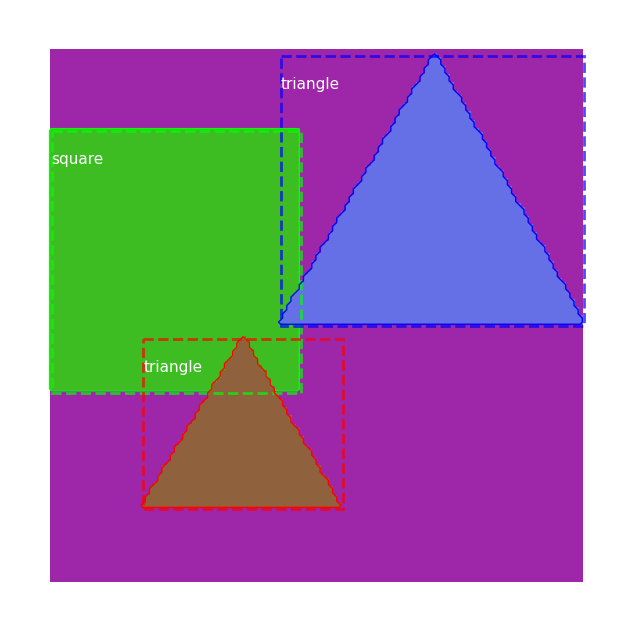

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


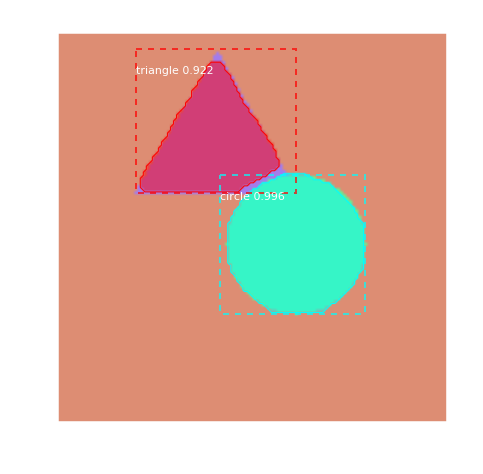

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
